In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from tqdm.auto import tqdm
import numpy as np
import random

import mimic3models.metrics as m
import matplotlib.pyplot as plt
import glob

from DataLoader import LoadDataSets
from lstm_cnn import LSTM_CNN4
from lstm_cnn import trainer, evaluate, calcMetrics, plotLoss, plotAUC

# Set random seeds

In [2]:
#CUDA RNN and LSTM
#In some versions of CUDA, RNNs and LSTM networks may have non-deterministic behavior. See torch.nn.RNN() and torch.nn.LSTM() for details and workarounds.
# https://pytorch.org/docs/stable/notes/randomness.html

def randseed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

randseed()

# Load Training, Test and Validation Data Sets

In [3]:
# if you want to evaluate models with MIMIC-III then sey mimic=False
# if you want to evaluate models with MIMIC-IV then sey mimic=True
mimic4 = True

In [4]:
try:
    del train_data
except:
    pass

try:
    del test_data
except:
    pass

try:
    del val_data
except:
    pass

already_loaded = False

dataloader_train, dataloader_val, dataloader_test = LoadDataSets(batch_size=64,mimic4=mimic4)

Loading train, test and validation data... from ../readmission/train_data_mimic4/
Dimensions Train Data:  21578 48 390
Dimensions:  7076 48 390
Dimensions:  7034 48 390


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Train a specific LSTM+CNN model

In [6]:
randseed()

# define threshold
threshold = 0.5
logit_threshold = torch.tensor (threshold / (1 - threshold)).log()
    
#best_accuracy = 0
#best_roc_auc = 0
#best_loss = 100000

## 128, 4, 0.001, 0.5, 0.3, 0.5) 100 epochs 0.76
## 24, 2, 0.001, 0.5, 0.5, 0.5) 30 epochs 0.76
#hidden_dim, lstm_layers, lr, dropout, dropout_w, dropout_conv = (16, 2, 1e-3/2, 0.5, 0.5, 0.5)
#print(hidden_dim, lstm_layers, lr, dropout, dropout_w, dropout_conv)

## 20210323 22:05 16, 2, 1e-3, 0.5, 0.2, 0.5

In [7]:
#number_epochs = 6

#(best_loss, best_accuracy, best_roc_auc), train_loss, val_loss,modelsignature = trainer(dataloader_train, dataloader_val,
#                                                                         number_epochs=number_epochs,
#                                                                         hidden_dim=hidden_dim,
#                                                                         lstm_layers=lstm_layers, lr=lr,
#                                                                         dropout=dropout,
#                                                                         dropout_w=dropout_w,
#                                                                         dropout_conv=dropout_conv,
#                                                                         best_loss=best_loss,
#                                                                         best_accuracy=best_accuracy,
#                                                                         best_roc_auc=best_roc_auc,
#                                                                         early_stopping=3,
#                                                                         verbatim=True)

##print((best_loss, best_accuracy, best_roc_auc), train_loss, val_loss)

# Run a sequence of trainings with one model to capture stats

In [8]:
number_epochs = 30
number_iterations = 30

overall_best_loss = 100000
overall_best_accuracy = 0.
overall_best_roc_auc = 0.
best_models = {}

hidden_dim, lstm_layers, lr, dropout, dropout_w, dropout_conv = (8, 2, 1e-3, 0.3, 0.2, 0.2) #(16, 3, 1e-3, 0.5, 0.3, 0.5) # default: (16, 2, 1e-3, 0.5, 0.5, 0.5)
#print(hidden_dim, lstm_layers, lr, dropout, dropout_w, dropout_conv)

results = []

for i in tqdm(range(number_iterations)):
    best_accuracy = 0
    best_roc_auc = 0
    best_loss = 100000
    (best_loss, best_accuracy, best_roc_auc), train_loss, val_loss, modelsignature = trainer(dataloader_train, dataloader_val,
         number_epochs=number_epochs,
         hidden_dim=hidden_dim,
         lstm_layers=lstm_layers, lr=lr,
         dropout=dropout,
         dropout_w=dropout_w,
         dropout_conv=dropout_conv,
         best_loss=best_loss,
         best_accuracy=best_accuracy,
         best_roc_auc=best_roc_auc,
         early_stopping=5,
         verbatim=False)
    
    results.append([best_loss, best_accuracy, best_roc_auc])

    if best_loss < overall_best_loss:
        best_models['loss'] = (best_loss, best_accuracy, best_roc_auc), train_loss, val_loss, modelsignature
        overall_best_loss = best_loss 
        
    if best_accuracy > overall_best_accuracy:
        best_models['acc'] = (best_loss, best_accuracy, best_roc_auc), train_loss, val_loss, modelsignature
        overall_best_accuracy = best_accuracy 
        
    if best_roc_auc > overall_best_roc_auc:
        best_models['auc'] = (best_loss, best_accuracy, best_roc_auc), train_loss, val_loss, modelsignature
        overall_best_roc_auc = best_roc_auc
        

  0%|          | 0/30 [00:00<?, ?it/s]

/system/apps/userenv/students/plasser/ICU_Readmission_Analysis_Pytorch_gpu/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [9]:
print("Results on Test Data Set:")
print(f"Best loss={overall_best_loss}, best accuracy={overall_best_accuracy}, and best AUC={overall_best_roc_auc}")

filename_loss = glob.glob(f"*{best_models['loss'][3]}*loss-{overall_best_loss}*.pth")[0]
filename_acc = glob.glob(f"*{best_models['acc'][3]}*acc-{overall_best_accuracy}*.pth")[0]
filename_auc = glob.glob(f"*{best_models['auc'][3]}*auc-{overall_best_roc_auc}.pth")[0]

print()
print("Files with the best values when evaluated against the test data set:")
print(filename_loss)
print(filename_acc)
print(filename_auc)

Results on Test Data Set:
Best loss=0.4815380871295929, best accuracy=0.7986150367439231, and best AUC=0.7693665621956213

Files with the best values when evaluated against the test data set:
model__30_8_2_0.001_0.3-0.2-0.2__epoch-0_loss-0.4815380871295929_acc-0.7683719615602035_auc-0.7503088323540595.pth
model__30_8_2_0.001_0.3-0.2-0.2__epoch-9_loss-0.5277599692344666_acc-0.7986150367439231_auc-0.7633610340739339.pth
model__30_8_2_0.001_0.3-0.2-0.2__epoch-10_loss-0.5138056874275208_acc-0.7671000565291125_auc-0.7693665621956213.pth


# Boxplot for Loss, Accuracy and AUC

(30, 3)
[0.51352655 0.76180045 0.76566205] [0.01325589 0.01479903 0.00167007] [0.53930008 0.79861504 0.76936656]


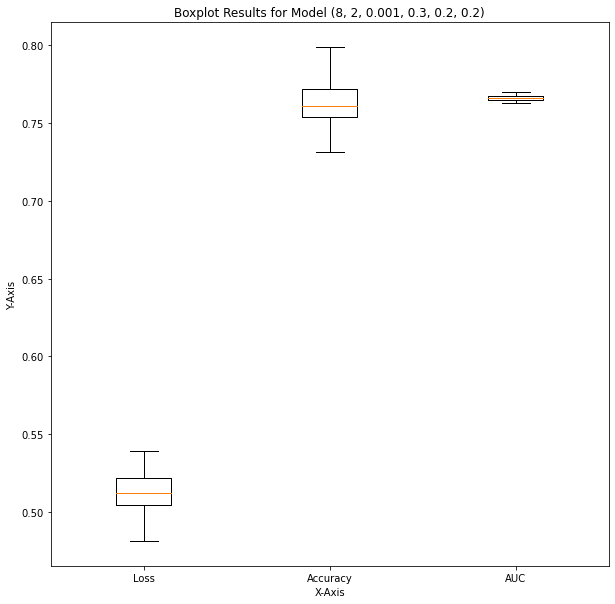

In [10]:
results = np.asarray(results)
print(results.shape)
print(results.mean(axis=0), results.std(axis=0),results.max(axis=0))

plt.figure(figsize=(10,10))
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title(f"Boxplot Results for Model {(hidden_dim, lstm_layers, lr, dropout, dropout_w, dropout_conv)}")
values = ["Loss", "Accuracy", "AUC"]
plt.boxplot(results)
plt.xticks([1, 2, 3], values)
None

# Evaluate best modell

In [11]:
model = LSTM_CNN4(hidden_dim=hidden_dim, lstm_layers=lstm_layers, dropout=0.5, dropout_w=0.5, dropout_conv=0.5)
model.to(device)

calcMetrics(model, dataloader_test, filename_loss, "Test Loss")
calcMetrics(model, dataloader_test, filename_acc, "Test Accuracy")
roc_auc, targets, outputs = calcMetrics(model, dataloader_test, filename_auc, "Test AUC")


Test Loss


/system/apps/userenv/students/plasser/ICU_Readmission_Analysis_Pytorch_gpu/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85      5716
         1.0       0.41      0.50      0.45      1318

    accuracy                           0.77      7034
   macro avg       0.64      0.67      0.65      7034
weighted avg       0.79      0.77      0.78      7034

Accuracy Score = 0.7691214102928632, Loss = 0.47906792163848877
--------------------
confusion matrix:
[[5461  255]
 [ 982  336]]
accuracy = 0.8241399
precision class 0 = 0.8475865
precision class 1 = 0.56852794
recall class 0 = 0.95538837
recall class 1 = 0.25493172
AUC of ROC = 0.749585063782838
AUC of PRC = 0.43342073152330035
ROC AUC =  0.749585063782838

Test Accuracy
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      5716
         1.0       0.45      0.41      0.43      1318

    accuracy                           0.80      7034
   macro avg       0.66      0.65      0.65      7034
weighted avg       0.79  

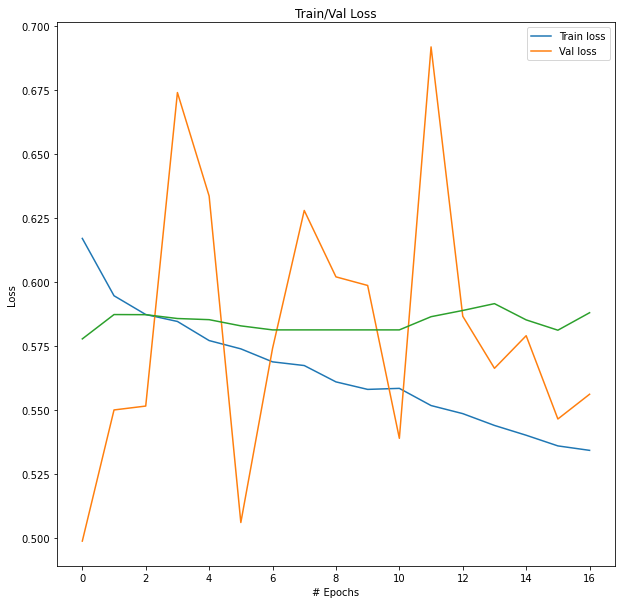

In [12]:
plotLoss(train_loss, val_loss)

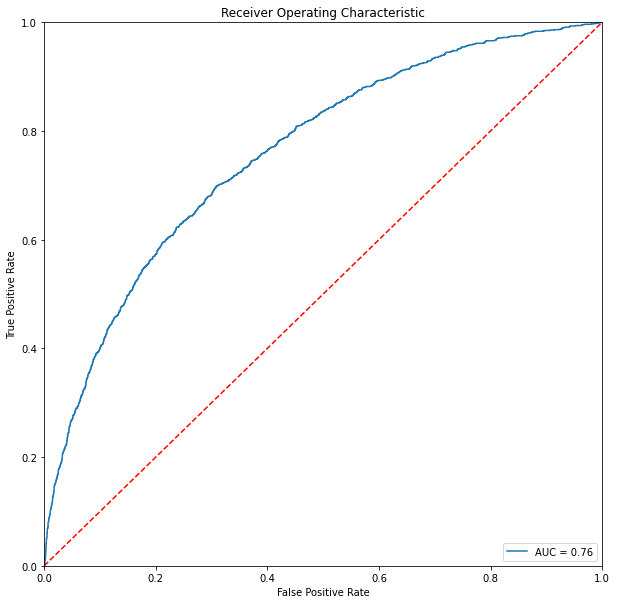

In [13]:
plotAUC(targets, outputs)